In [1]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Video, widgets
from IPython.display import display

%matplotlib inline

In [2]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

## Utils
Important functions and some useful utils

In [3]:
def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

def save_first_frame(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Release the video capture object
    cap.release()

    return frame

def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

def get_closest_corners(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    dst = cv2.cornerHarris(blurred, 7, 3, 0.02)
    dst = cv2.dilate(dst, None)
    corners = np.argwhere(dst > 0.01 * dst.max())

    # Find corners closest to image corners
    image_corners = np.array([[0, 0], [0, frame.shape[1]], [frame.shape[0], 0], [frame.shape[0], frame.shape[1]]])
    closest_corners = find_closest_points_to_corners(corners, image_corners)

    return closest_corners

def get_target_points(target_square_size=1000):
    target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
    return target_points

def detect_hand(frame, show_threshold=False):
    img_hls = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)

    # Define the skin color range in HLS
    skin_color_lower = np.array([0, 190, 100], dtype=np.uint8)
    skin_color_upper = np.array([15, 240, 255], dtype=np.uint8)

    # Create a mask using the skin color range
    range_mask = cv2.inRange(img_hls, skin_color_lower, skin_color_upper)

    # Remove noise with blurring
    blurred = cv2.blur(range_mask, (10, 10))

    # Threshold the blurred image to create a binary mask
    _, thresholded = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

    roi1 = thresholded[0:img_hls.shape[0], 0:img_hls.shape[1]//2]
    roi2 = thresholded[0:int(img_hls.shape[0]/1.7), img_hls.shape[1]//2:img_hls.shape[1]]

    if show_threshold:
        cv2.imshow('Threshold hand', thresholded)

    if np.any(roi1 == 255) or np.any(roi2 == 255):
        return True
    
    return False

# def get_squares_occupation(calibrated_image, grid_division, show_img=True):
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     font_scale = 0.75
#     thickness = 2

#     square_size = grid_division[1] - grid_division[0]

#     calibrated_gray = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2GRAY)
#     calibrated_edges = cv2.Canny(calibrated_gray, 50, 150)

#     space_img = calibrated_image.copy()

#     empty_check_offset = 20
#     kernel_size = square_size - empty_check_offset
#     artifact_tolerance = 300
#     col_imgs = []
#     square_color = "Black"
#     for x in grid_division[:-1]:
#         row_imgs = []
#         for y in grid_division[:-1]:
#             x_d = x+empty_check_offset//2, x+empty_check_offset//2+kernel_size
#             y_d = y+empty_check_offset//2, y+empty_check_offset//2+kernel_size

#             edge_board_square = calibrated_edges[x_d[0]:x_d[1], y_d[0]:y_d[1]]
#             edge_board_square_bin = np.where(edge_board_square==255, 1, edge_board_square)
#             edge_board_square_value = np.sum(edge_board_square_bin)

#             row_imgs.append(edge_board_square)
#             # imshow(resize_img(edge_board_square, 1))

#             if edge_board_square_value > artifact_tolerance:
#                 # cv2.putText(space_img, f"{square_color} sq", (y+20, x+50), font, font_scale, font_color, thickness)
#                 cv2.putText(space_img, f"Figure", (y+16, x+60), font, font_scale, (0, 0, 255), thickness)

#             elif edge_board_square_value <= artifact_tolerance:
#                 # cv2.putText(space_img, f"{square_color} sq", (y+20, x+50), font, font_scale, font_color, thickness)
#                 cv2.putText(space_img, f"Empty", (y+16, x+60), font, font_scale, (0, 255, 0), thickness)
                
#             square_color = "White" if square_color == "Black" else "Black"
                
#         square_color = "White" if square_color == "Black" else "Black"

#         # imshow(resize_img(np.concatenate(row_imgs, 1), 1))
#         col_imgs.append(np.concatenate(row_imgs, 1))

#     if show_img:
#         cv2.imshow('Labelled_img', space_img)

#     return space_img

def get_squares_occupation2(calibrated_image, grid_division):
    img_rgb = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2RGB)

    lower_blue = np.array([50, 105, 155], dtype=np.uint8)
    upper_blue = np.array([100, 150, 170], dtype=np.uint8)

    lower_pink = np.array([200, 100, 160], dtype=np.uint8)
    upper_pink = np.array([230, 170, 200], dtype=np.uint8)

    mask_lb = cv2.inRange(img_rgb, lower_blue, upper_blue)
    mask_p = cv2.inRange(img_rgb, lower_pink, upper_pink)
    kernel1 = np.ones((3, 3), np.uint8)
    kernel2 = np.ones((7, 7), np.uint8)

    # mask = mask_lb+mask_p
    dilated_mask_lb = cv2.dilate(mask_lb, kernel1, iterations=2)
    closed_mask_lb = cv2.morphologyEx(dilated_mask_lb, cv2.MORPH_CLOSE, kernel2)
    bin_mask_lb = np.where(closed_mask_lb==255, 1, 0)


    dilated_mask_p = cv2.dilate(mask_p, kernel1, iterations=2)
    closed_mask_p = cv2.morphologyEx(dilated_mask_p, cv2.MORPH_CLOSE, kernel2)
    bin_mask_p = np.where(closed_mask_p==255, 1, 0)

    for i in range(len(grid_division[:-1])):
        for j in range(len(grid_division[:-1])):
            square_lb = bin_mask_lb[grid_division[i]+10:grid_division[i+1]-10, grid_division[j]+10:grid_division[j+1]-10]
            square_p = bin_mask_p[grid_division[i]+10:grid_division[i+1]-10, grid_division[j]+10:grid_division[j+1]-10]
            one_square = np.ones_like(square_lb)

            if np.any(square_lb==1):
                cv2.putText(calibrated_image, f'Blue', (grid_division[j]+16, grid_division[i]+60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                # cv2.putText(calibrated_image, f'White', (grid_division[j]+16, grid_division[i]+60),
                        # cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
                
            if np.any(square_p==1):
                cv2.putText(calibrated_image, f'Pink', (grid_division[j]+16, grid_division[i]+60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (230, 180, 200), 2)
                # cv2.putText(calibrated_image, f'Black', (grid_division[j]+16, grid_division[i]+60),
                        # cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                
    return calibrated_image

def get_corner_diff(ref_corners, new_corners):
    ref_corners = np.array(ref_corners)
    new_corners = np.array(new_corners)

    distances = np.linalg.norm(ref_corners - new_corners, axis=1)
    
    return distances

def correct_corners(corners, ref_corners, marked_change):
    updated_corners = corners.copy()
    good_corners = [(corner, id) for id, corner in enumerate(corners) if not marked_change[id]]
    bad_corners = [(corner, id) for id, corner in enumerate(corners) if marked_change[id]]

    num_incorrect = len(bad_corners)
    
    # print(corners)
    if num_incorrect == 0:
        return corners
    if num_incorrect == 4:
        return ref_corners
    
    # if 2 in [id for _, id in good_corners]:
    #     good_corner, g_id = corners[2], 2
        
    # elif 1 in [id for _, id in good_corners]:
    #     good_corner, g_id = corners[1], 1

    # else:
    good_corner, g_id = good_corners[-1]
    
    for bad_corner, b_id in bad_corners:
        delta_x = ref_corners[b_id][0] - ref_corners[g_id][0]
        delta_y = ref_corners[b_id][1] - ref_corners[g_id][1]

        # Update the position of the faulty corner based on the difference
        updated_corners[b_id][0] = good_corner[0] + delta_x
        updated_corners[b_id][1] = good_corner[1] + delta_y
        
        # print(bad_corner, updated_corners[b_id][0], updated_corners[b_id][1])

    return updated_corners

    # for bad_corner, b_id in bad_corners:
    #     corner_x = []
    #     corner_y = []
    #     for good_corner, g_id in good_corners:
    #         delta_x = ref_corners[b_id][0] - ref_corners[g_id][0]
    #         delta_y = ref_corners[b_id][1] - ref_corners[g_id][1]

    #         corner_x.append(good_corner[0] + delta_x)
    #         corner_y.append(good_corner[1] + delta_y)

    #     # Update the position of the faulty corner based on the mean differences
    #     updated_corners[b_id][0] = np.mean(corner_x)
    #     updated_corners[b_id][1] = np.mean(corner_y)

In [4]:
video_path = 'Chess_Data\\chess_new_B.mp4'

# Camera calibration

## Solution1:
Correct shifted corners based on relative position to a stable corner from previous frame

In [5]:
video_capture = cv2.VideoCapture(video_path)

target_square_size = 1000  # Adjust the size as needed
target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)

is_first_frame = True
distance_threshold = 7
history_queue = []
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    closest_corners = get_closest_corners(frame)

    if is_first_frame:
        ref_corners = closest_corners.copy()
        is_first_frame = False

    # If change in corners is big, use last accepted reference corners
    distances = get_corner_diff(ref_corners, closest_corners)

    marked_change = [False, False, False, False]
    for c in range(4):
        if distances[c] > distance_threshold:
            marked_change[c] = True

    corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
    ref_corners = corrected_corners.copy()

    homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

    # Apply the perspective transformation
    calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_image.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # Display the result
    # cv2.imshow('Chessboard focus', grid_img)

    # Display the result
    # cv2.imshow('Chessboard focus', calibrated_image)
        
    img2 = get_squares_occupation2(calibrated_image, grid_division)
    cv2.imshow('Chessboard focus', img2)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

## Solution 2:
From B_track_corners.ipynb

Use trackers to determine change in homography matrix used for calibration

In [6]:
def create_mosse_tracker(image, point, offset=40):
    tracker = cv2.legacy.TrackerMOSSE_create()
    bbox = (point[0]-offset, point[1]-offset, 2*offset, 2*offset)
    tracker.init(image, bbox)
    return tracker, bbox

def euclidean_distance(point1, point2):
    x1, y1 = point1[:-2]
    x2, y2 = point2[:-2]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def euclidean_distance_bboxes(bboxes1, bboxes2, succesful_tracking):
    bboxes1 = np.array(bboxes1[:-2])
    bboxes2 = np.array(bboxes2[:-2])

    distances = np.linalg.norm(bboxes1 - bboxes2, axis=1)
    
    # Penalize unsuccessfully tracked points 
    distances = np.array([x if succesful_tracking[i] else 99999 for i, x in enumerate(distances)])
    return distances

def find_new_homography_matrix(prev_homography_matrix, ref_ids, current_bboxes, previous_bboxes):
    new_homography_matrix = prev_homography_matrix.copy()    
    ref_ids = set(ref_ids)
    current_points = np.array([(x[0], x[1]) for i, x in enumerate(current_bboxes) if i in ref_ids], dtype=int)
    previous_points = np.array([(x[0], x[1]) for i, x in enumerate(previous_bboxes) if i in ref_ids], dtype=int)
    perspective_change = current_points - previous_points
    # print(current_points[0], previous_points[0])

    # Update the homography matrix based on the perspective change
    new_homography_matrix[0, 2] -= np.median(perspective_change[:, 0])
    new_homography_matrix[1, 2] -= np.median(perspective_change[:, 1])
    # print(np.mean(perspective_change[:, 0]))
    return new_homography_matrix

# Poor results
# def initialize_trackers_grid(grid, trackers, frame, point_offset=40):
#     # print("i")
#     new_trackers = []
#     grid_points = [[x, y] for x in grid for y in grid]
#     bboxes = []
#     for i, point in enumerate(grid_points):
#         # bbox = (point[0]-point_offset, point[1]-point_offset, 2*point_offset, 2*point_offset)
#         # trackers[i].init(frame, bbox)
#         tracker, bbox = create_mosse_tracker(frame, point, offset=point_offset)
#         new_trackers.append(tracker)
#         bboxes.append(bbox)

#     return new_trackers, bboxes

### For original space

In [7]:
first_frame = save_first_frame(video_path)

In [8]:
closest_corners = get_closest_corners(first_frame)
target_points = get_target_points(target_square_size=1000)

closest_corners = np.array([[[y, x]] for x, y in closest_corners], dtype=int)

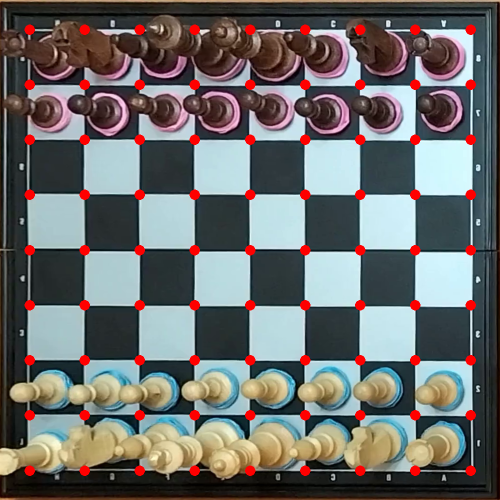

In [9]:
homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

# Apply the perspective transformation
calibrated_image = cv2.warpPerspective(first_frame, homography_matrix, (target_square_size, target_square_size))

grid_img = calibrated_image.copy()
offset = 59 # Board edge offset
grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
# for x in grid_division:
#     cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
#     cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)
points = []  
for x in grid_division:
    for y in grid_division:
        points.append((x, y))
        cv2.circle(grid_img, (x, y), 5, (0, 0, 255), 10)

imshow(resize_img(grid_img, 2))

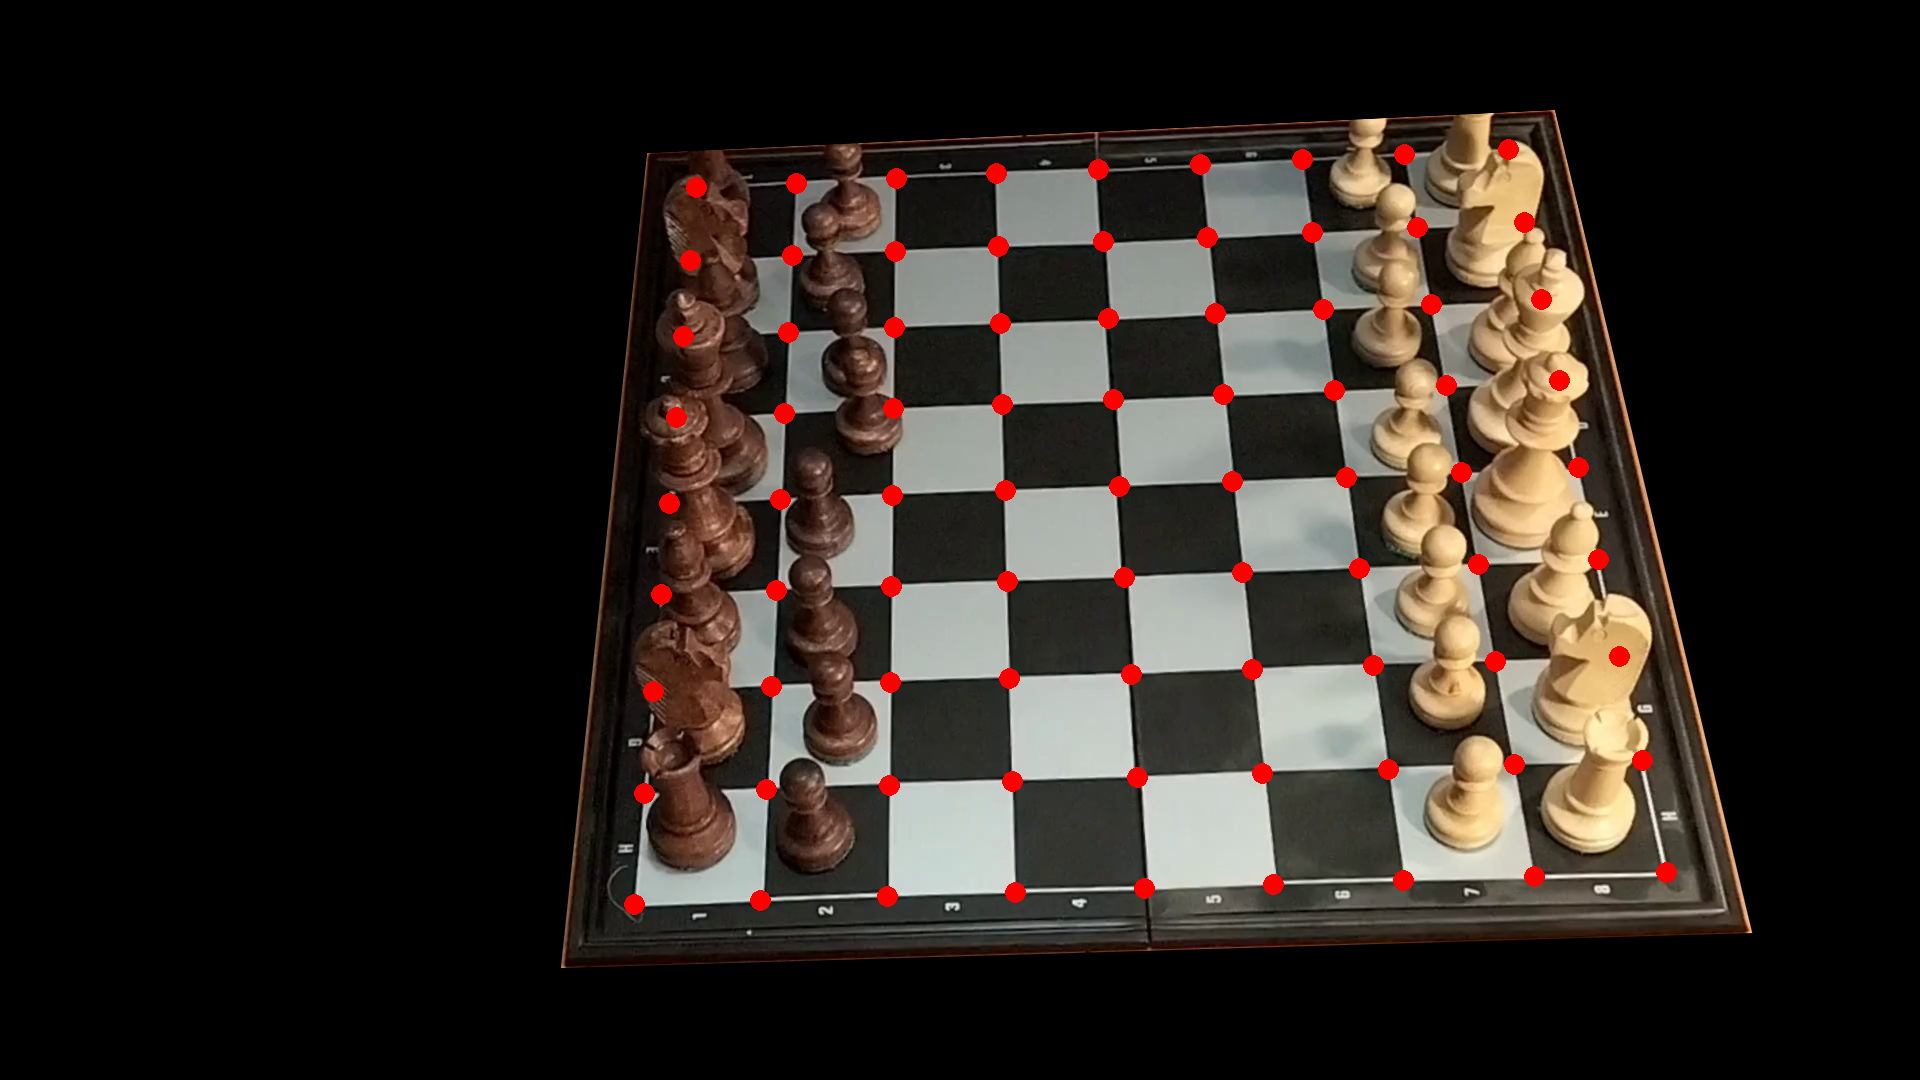

In [16]:
# Invert the homography matrix to get the reverse transformation
inverse_homography_matrix = np.linalg.inv(homography_matrix)
reverted_image = cv2.warpPerspective(calibrated_image, inverse_homography_matrix, (first_frame.shape[1], first_frame.shape[0]))

points = np.array(points, dtype=int)
calibrated_points_homogeneous = np.column_stack((points, np.ones(len(points))))
original_points_homogeneous = np.dot(inverse_homography_matrix, calibrated_points_homogeneous.T).T
original_points = original_points_homogeneous[:, :2] / original_points_homogeneous[:, 2:]

for point in original_points:
    cv2.circle(reverted_image, point.astype(int), 5, (0, 0, 255), 10)

imshow(reverted_image)

### For calibrated space with frame lag
This is the best current solution with trackers but there are other options that might still be considered in B_track_corners.ipynb

In [21]:
trackers = []
current_bboxes = []
point_offset = 60
for point in points:
    tracker, bbox = create_mosse_tracker(calibrated_image, point, offset=point_offset)
    current_bboxes.append(bbox)
    trackers.append(tracker)

video_capture = cv2.VideoCapture(video_path)

ref_id_count = 15

prev_homography_matrix = homography_matrix.copy()
previous_bboxes = current_bboxes.copy()
frame_count = 0
while True:
    frame_count += 1
    # Read a new frame
    ret, frame = video_capture.read()

    # Break the loop if the video has ended
    if not ret:
        break

    # Calibrate frame based on previous matrix
    calibrated_frame = cv2.warpPerspective(frame, prev_homography_matrix, (target_square_size, target_square_size))

    current_bboxes = []
    successful_ids = [False] * len(trackers)
    # Update the MOSSE trackers
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(calibrated_frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_bboxes.append(bbox)
            successful_ids[i] = True
            # cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
            # cv2.circle(calibrated_frame, (bbox[0]+40, bbox[1]+40), 5, (0, 255, 0), 10)

        else:
            current_bboxes.append(previous_bboxes[i])
    
    distances = euclidean_distance_bboxes(current_bboxes, previous_bboxes, successful_ids)
    distance_ids = [(i, distance) for i, distance in zip(range(len(trackers)), distances)]
    distance_ids.sort(key=lambda x: x[1])

    # Take x bboxes with least change into consideration !! Wrong - uses points that do not change on calibrated image instead of the original
    ref_ids = [x[0] for x in distance_ids[:ref_id_count]]

    for i, bbox in enumerate(current_bboxes):
        if i in set(ref_ids):
            cv2.circle(calibrated_frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 0, 255), 10)
        else:
            cv2.circle(calibrated_frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 255, 0), 10)

    # Create new homography matrix based on change in least changed trackers?
    prev_homography_matrix = find_new_homography_matrix(prev_homography_matrix, ref_ids, current_bboxes, previous_bboxes)
    # previous_bboxes = current_bboxes
    grid_img = calibrated_frame.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # if frame_count == 5*30:
    #     frame_count = 0
    #     trackers, current_bboxes = initialize_trackers_grid(grid_division, trackers, calibrated_frame, point_offset=80)

    cv2.imshow('MOSSE Tracker', grid_img)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

# Hand detection
### To view thresholding in action change 
```py
if detect_hand(frame, show_threshold=False)
        cv2.putText(frame, f"Hand detected!", (20, 100), font, font_scale, (0, 255, 0), thickness)

# Display the frame with hand detection
cv2.imshow('Hand Detection', frame)
```

For:
```py
if detect_hand(frame, show_threshold=True):
    cv2.putText(frame, f"Hand detected!", (20, 100), font, font_scale, (0, 255, 0), thickness)

# Display the frame with hand detection
# cv2.imshow('Hand Detection', frame)
```

In [11]:
video_capture = cv2.VideoCapture('Chess_Data\\chess_hard1.mp4')

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
thickness = 2

i = 0
while True:
    i += 1
    ret, frame = video_capture.read()

    if not ret:
        break
    
    if detect_hand(frame, show_threshold=False):
        cv2.putText(frame, f"Hand detected!", (20, 100), font, font_scale, (0, 255, 0), thickness)

    # Display the frame with hand detection
    cv2.imshow('Hand Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

## Empty spaces (with corner correction)

In [22]:
video_capture = cv2.VideoCapture(video_path)

target_square_size = 1000  # Adjust the size as needed
target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)

is_first_frame = True
distance_threshold = 7
history_queue = []
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    closest_corners = get_closest_corners(frame)

    if is_first_frame:
        ref_corners = closest_corners.copy()
        is_first_frame = False

    # If change in corners is big, use last accepted reference corners
    distances = get_corner_diff(ref_corners, closest_corners)

    marked_change = [False, False, False, False]
    for c in range(4):
        if distances[c] > distance_threshold:
            marked_change[c] = True

    corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
    ref_corners = corrected_corners.copy()

    homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

    # Apply the perspective transformation
    calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_image.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    # for x in grid_division:
    #     cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
    #     cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    get_squares_occupation(calibrated_image, grid_division, show_img=True)

    # Display the result
    # cv2.imshow('Chessboard focus', grid_img)

    # Display the result
    # cv2.imshow('Chessboard focus', calibrated_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

# Visualize game state

https://python-chess.readthedocs.io/en/latest/

In [6]:
# !pip install chess

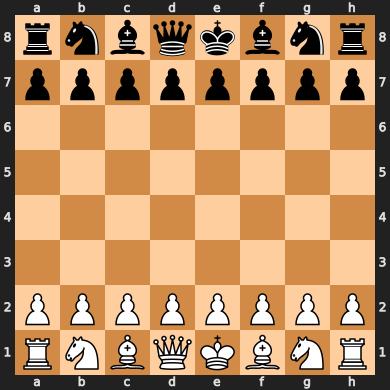

In [7]:
import chess

board = chess.Board()
board